# Прогнозирование сезонности продажи продуктов


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.utils import resample

import os
import csv
import glob
import time
import zipfile
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file = '/content/drive/My Drive/Predicting_HardDrive_Failures_with_ML/new_data.zip'       # for test

with zipfile.ZipFile(zip_file, 'r') as z:
    z.extractall('/content/dataset')

print(f'[ Каталоги ] >>> \n{os.listdir()}')

[ Каталоги ] >>> 
['.config', 'drive', 'dataset', 'sample_data']


In [5]:
def split_and_save_csv_files(path):
  import shutil
  from sklearn.model_selection import train_test_split

  filenames = glob.glob(os.path.join(path, "*.csv"))

  dfs = []

  for filename in filenames:
    dfs.append(pd.read_csv(filename))

  data = pd.concat(dfs, ignore_index=True)

  data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

  data_train.to_csv('/content/data_train.csv', index=False)
  data_test.to_csv('/content/data_test.csv', index=False)

  shutil.rmtree(path)


split_and_save_csv_files('/content/dataset')

In [6]:
df_train = pd.read_csv('data_train.csv').sample(frac=1).reset_index(drop=True).head(150000)
df_test = pd.read_csv('data_test.csv').sample(frac=1).reset_index(drop=True).head(45000)

In [7]:
df_train.head()

,Unnamed: 0,Product_Name,Product_Cost,Manufacture_Date,Expiry_Date,SKU,Store_Name,Store_Address,Region,Sale_Date,...,Product_Volume,Manufacturer,Year,Month,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale,Comparison,Sales_Velocity_Coefficient
0,689132,Кефир,380.4,2020-11-24 10:40:06,2020-12-01 10:40:06,1011,Фермерский район,"ул. Победы, 75",Краснодар,2020-11-28 10:40:06,...,0.0044,"ОАО ""Молокозавод №1""",2020,11,0.986341,484.321259,0,7,3,1
1,146708,Оливковое масло,157.3,2021-06-10 21:11:51,2021-12-07 21:11:51,1032,Эко ферма,"ул. Маяковского, 18",Воронеж,2021-09-16 21:11:51,...,0.0002,"Фермерское хозяйство ""Олива""",2021,9,0.944582,930.382416,0,180,82,1
2,584359,Хлеб,61.4,2020-05-22 09:42:25,2020-05-29 09:42:25,1015,Фермерский сад,"ул. Космонавтов, 12",Краснодар,2020-05-22 09:42:25,...,0.0018,"Пекарня ""Хлебушек""",2020,5,0.965219,111.357355,0,7,7,0
3,309526,Сыр,499.2,2020-09-11 10:42:36,2020-10-21 10:42:36,1041,Фермерский мир,"ул. Кирова, 63",Краснодар,2020-09-17 10:42:36,...,0.0005,"Агроконцерн ""ЭкоПоляна""",2020,9,1.055307,1623.867225,0,40,34,0
4,437350,Огурцы маринованные,89.9,2022-12-14 13:36:30,2023-06-12 13:36:30,1038,Органик маркет,"ул. Московская, 42",Москва,2023-05-31 13:36:30,...,0.0008,"ООО ""Закуска""",2023,5,1.027000,371.498416,0,180,12,1


In [8]:
df_train.describe()

,Unnamed: 0,Product_Cost,SKU,Quantity_Sold,Product_Amount,Product_Volume,Year,Month,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale,Comparison,Sales_Velocity_Coefficient
count,150000.00000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000
mean,498866.72908,368.717789,1022.961087,2.361851,337.371576,0.002690,2021.572527,6.505500,1.077743,541.395194,0.000113,54.68528,27.866900,0.444327
std,288959.12670,402.339437,12.795570,1.327954,643.119221,0.003548,1.146619,3.455482,0.743226,476.655481,0.010645,83.21172,50.732694,0.496892
min,2.00000,-54.640000,1001.000000,-0.207600,-0.207600,-0.000500,2020.000000,1.000000,0.071317,49.587962,0.000000,3.00000,1.000000,0.000000
25%,248659.00000,84.220000,1012.000000,1.307200,1.433600,0.001200,2021.000000,3.000000,0.979560,148.724522,0.000000,7.00000,4.000000,0.000000
50%,497092.00000,234.000000,1023.000000,2.000000,2.100350,0.002000,2022.000000,7.000000,1.005774,395.007390,0.000000,20.00000,8.000000,0.000000
75%,749282.25000,474.410000,1034.000000,3.000000,400.000000,0.003000,2023.000000,10.000000,1.037691,752.881311,0.000000,60.00000,27.000000,1.000000
max,999996.00000,3484.730000,1044.000000,5.000000,2750.000000,0.036000,2024.000000,12.000000,12.000000,2264.138732,1.000000,365.00000,365.000000,1.000000


In [9]:
df_test.head()

,Unnamed: 0,Product_Name,Product_Cost,Manufacture_Date,Expiry_Date,SKU,Store_Name,Store_Address,Region,Sale_Date,...,Product_Volume,Manufacturer,Year,Month,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale,Comparison,Sales_Velocity_Coefficient
0,889251,Картофель,30.01,2023-02-18 21:34:29,2023-03-20 21:34:29,1024,Здоровое питание,"ул. Горького, 15",Тверь,2023-02-25 21:34:29,...,0.0016,"ООО ""Картофан""",2023,2,0.938725,279.567570,0,30,23,0
1,898685,Картофель,48.93,2022-09-03 17:56:57,2022-10-03 17:56:57,1024,Фермерская ярмарка,"ул. Чехова, 10",Ростов-на-Дону,2022-09-06 17:56:57,...,0.0027,"ООО ""Картофан""",2022,9,1.029529,225.700949,0,30,27,0
2,906219,Свинина,295.42,2021-12-17 21:31:16,2021-12-20 21:31:16,1036,Зеленый круг,"ул. Лесная, 15",Тверь,2021-12-18 21:31:16,...,0.0010,"Агроконцерн ""ЭкоПоляна""",2021,12,0.988070,771.314022,0,3,2,0
3,345092,Морковь,54.99,2023-09-15 21:51:48,2023-09-29 21:51:48,1014,Фермерская лавка,"ул. Маяковского, 1",Краснодар,2023-09-28 21:51:48,...,0.0017,"Агроконцерн ""ЭкоПоляна""",2023,9,0.992527,78.562498,0,14,1,1
4,174557,Масло,497.20,2020-09-03 12:01:09,2020-10-03 12:01:09,1019,Фермерский мир,"ул. Кирова, 63",Краснодар,2020-09-16 12:01:09,...,0.0040,"Агроконцерн ""ЭкоПоляна""",2020,9,1.020763,456.766137,0,30,17,0


In [10]:
df_test.describe()

,Unnamed: 0,Product_Cost,SKU,Quantity_Sold,Product_Amount,Product_Volume,Year,Month,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale,Comparison,Sales_Velocity_Coefficient
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,500054.900867,374.704941,1022.896356,2.369644,343.646307,0.002689,2021.584667,6.538133,1.069923,544.502703,0.000067,54.649022,27.772422,0.441667
std,289130.175875,409.273203,12.835230,1.331484,650.300738,0.003557,1.144948,3.441228,0.691425,478.747973,0.008165,82.690786,50.262956,0.496591
min,14.000000,3.950000,1001.000000,0.076100,0.076100,0.000100,2020.000000,1.000000,0.098918,49.587962,0.000000,3.000000,1.000000,0.000000
25%,249295.750000,85.100000,1012.000000,1.316975,1.435600,0.001200,2021.000000,4.000000,0.979560,148.044194,0.000000,7.000000,4.000000,0.000000
50%,500647.000000,239.300000,1023.000000,2.000000,2.087950,0.002000,2022.000000,7.000000,1.005774,395.207965,0.000000,20.000000,8.000000,0.000000
75%,750193.000000,481.000000,1034.000000,3.000000,450.000000,0.003000,2023.000000,10.000000,1.037523,760.826515,0.000000,60.000000,28.000000,1.000000
max,999981.000000,3699.550000,1044.000000,5.000000,2750.000000,0.036000,2024.000000,12.000000,12.000000,2264.138732,1.000000,365.000000,365.000000,1.000000


In [11]:
print(f'[ Размер тренировочной выборки ] >>> {df_train.shape}')
print(f'[ Размер тестовой выборки ] >>> {df_test.shape}')

[ Размер тренировочной выборки ] >>> (150000, 23)
[ Размер тестовой выборки ] >>> (45000, 23)


In [12]:
target = 'New_Column_Name'

In [ ]:
sns.countplot(df_train['New_Column_Name'])

### Балансировка набора данных

In [169]:
valid = df_train[df_train['New_Column_Name'] == 0]
failed = df_train[df_train['New_Column_Name'] == 1]

print("[ Число продажных продуктов ] >>> ", len(valid))
print("[ Число нерподажных продуктов ] >>> ", len(failed))

[ Число продажных продуктов ] >>>  99986
[ Число нерподажных продуктов ] >>>  14


In [170]:
if len(valid) > 0:
    failed_up = resample(failed, replace=True, n_samples=len(valid), random_state=27)

else:
    print("Недостаточно данных в переменной 'valid'")

In [171]:
df_train = pd.concat([valid,failed_up])
df_train.New_Column_Name.value_counts()

New_Column_Name
0    99986
1    99986
Name: count, dtype: int64

<Axes: ylabel='count'>

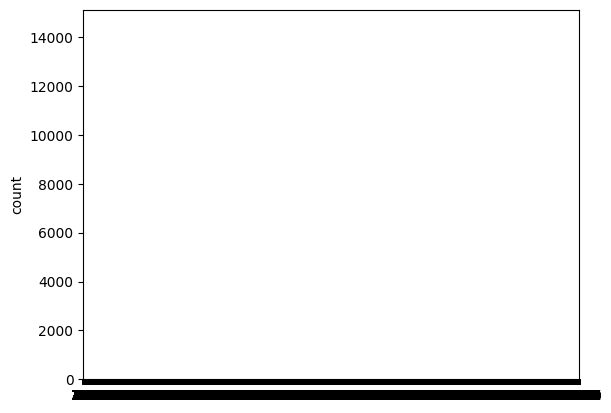

In [26]:
sns.countplot(df_train['New_Column_Name'])

In [172]:
df_train

,Unnamed: 0,Product_Name,Product_Cost,Manufacture_Date,Expiry_Date,SKU,Store_Name,Store_Address,Region,Sale_Date,...,Product_Volume,Manufacturer,Year,Month,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale,Comparison,Sales_Velocity_Coefficient
0,738394,Огурцы маринованные,246.90,2021-11-14 12:05:17,2022-05-13 12:05:17,1038,Эко сад,"пр. Мира, 60",Воронеж,2021-12-11 12:05:17,...,0.0023,"ООО ""Закуска""",2021,12,1.033397,340.983623,0,180,153,0
1,647064,Огурцы маринованные,285.30,2023-11-21 14:39:10,2024-05-19 14:39:10,1038,Натур продукт,"ул. Пушкинская, 5",Санкт-Петербург,2024-05-06 14:39:10,...,0.0023,"ООО ""Закуска""",2024,5,0.979413,356.555840,0,180,13,1
2,35872,Кефир,444.40,2023-12-26 12:23:39,2024-01-02 12:23:39,1011,Фермерский мир,"ул. Кирова, 63",Краснодар,2023-12-30 12:23:39,...,0.0044,"ОАО ""Молокозавод №1""",2023,12,1.006484,376.725141,0,7,3,1
3,501574,Куриное яйцо,123.60,2020-08-06 15:53:55,2020-08-26 15:53:55,1025,Органик дом,"ул. Ленина, 70",Москва,2020-08-16 15:53:55,...,0.0048,"Птицефабрика ""Яичная радость""",2020,8,1.005904,366.834728,0,20,10,0
4,156993,Творог,182.40,2022-03-10 20:38:15,2022-03-30 20:38:15,1021,Фермерская дача,"ул. Советская, 40",Ростов-на-Дону,2022-03-28 20:38:15,...,0.0009,"ОАО ""Молокозавод №1""",2022,3,1.077325,431.501318,0,20,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60910,484240,Свинина,580.77,2023-12-31 11:36:21,2024-01-03 11:36:21,1036,Фермерский дом,"ул. Гагарина, 28",Ростов-на-Дону,2024-01-01 11:36:21,...,0.0018,"Агроконцерн ""ЭкоПоляна""",2024,1,12.000000,768.656079,1,3,2,0
45505,521981,Свинина,528.20,2023-12-31 10:59:54,2024-01-03 10:59:54,1036,Натуральный выбор,"пр. Невский, 45",Санкт-Петербург,2024-01-02 10:59:54,...,0.0016,"Агроконцерн ""ЭкоПоляна""",2024,1,12.000000,768.656079,1,3,1,1
60025,369169,Свинина,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,1036,Органический уголок,"ул. Пушкина, 15",Тверь,2024-01-01 12:43:03,...,0.0015,"Агроконцерн ""ЭкоПоляна""",2024,1,12.000000,768.656079,1,3,1,1
60025,369169,Свинина,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,1036,Органический уголок,"ул. Пушкина, 15",Тверь,2024-01-01 12:43:03,...,0.0015,"Агроконцерн ""ЭкоПоляна""",2024,1,12.000000,768.656079,1,3,1,1


In [173]:
df_train.shape

(199972, 23)

In [174]:
# For the training data
df_train.isnull().sum()

Unnamed: 0                    0
Product_Name                  0
Product_Cost                  0
Manufacture_Date              0
Expiry_Date                   0
SKU                           0
Store_Name                    0
Store_Address                 0
Region                        0
Sale_Date                     0
Quantity_Sold                 0
Product_Amount                0
Product_Measure               0
Product_Volume                0
Manufacturer                  0
Year                          0
Month                         0
Demand_Coefficient            0
Average_Price                 0
New_Column_Name               0
Days_for_sale                 0
Comparison                    0
Sales_Velocity_Coefficient    0
dtype: int64

In [175]:
features = [
    'Manufacture_Date',
    'Expiry_Date',
    'Sale_Date',
    'Quantity_Sold',
    'Product_Cost',
    'New_Column_Name',
    'Demand_Coefficient','Average_Price','Days_for_sale'
]

In [176]:
misc_feat = [fname for fname in df_train if fname not in features]
misc_feat

['Unnamed: 0',
 'Product_Name',
 'SKU',
 'Store_Name',
 'Store_Address',
 'Region',
 'Product_Amount',
 'Product_Measure',
 'Product_Volume',
 'Manufacturer',
 'Year',
 'Month',
 'Comparison',
 'Sales_Velocity_Coefficient']

In [177]:
df_train.drop(misc_feat, inplace=True, axis=1)

In [178]:
df_train

,Product_Cost,Manufacture_Date,Expiry_Date,Sale_Date,Quantity_Sold,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale
0,246.90,2021-11-14 12:05:17,2022-05-13 12:05:17,2021-12-11 12:05:17,3.0000,1.033397,340.983623,0,180
1,285.30,2023-11-21 14:39:10,2024-05-19 14:39:10,2024-05-06 14:39:10,3.0000,0.979413,356.555840,0,180
2,444.40,2023-12-26 12:23:39,2024-01-02 12:23:39,2023-12-30 12:23:39,4.0000,1.006484,376.725141,0,7
3,123.60,2020-08-06 15:53:55,2020-08-26 15:53:55,2020-08-16 15:53:55,3.0000,1.005904,366.834728,0,20
4,182.40,2022-03-10 20:38:15,2022-03-30 20:38:15,2022-03-28 20:38:15,2.0000,1.077325,431.501318,0,20
...,...,...,...,...,...,...,...,...,...
60910,580.77,2023-12-31 11:36:21,2024-01-03 11:36:21,2024-01-01 11:36:21,1.4733,12.000000,768.656079,1,3
45505,528.20,2023-12-31 10:59:54,2024-01-03 10:59:54,2024-01-02 10:59:54,1.3136,12.000000,768.656079,1,3
60025,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,2024-01-01 12:43:03,1.2204,12.000000,768.656079,1,3
60025,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,2024-01-01 12:43:03,1.2204,12.000000,768.656079,1,3


In [179]:
obj = df_train.dtypes[df_train.dtypes == object ].index
obj

Index(['Manufacture_Date', 'Expiry_Date', 'Sale_Date'], dtype='object')

In [180]:
df_train = df_train.drop(obj,axis=1)

In [181]:
df_train.isnull().sum()

Product_Cost          0
Quantity_Sold         0
Demand_Coefficient    0
Average_Price         0
New_Column_Name       0
Days_for_sale         0
dtype: int64

In [182]:
df_train['Product_Cost'] = df_train['Product_Cost'].fillna(0)

In [183]:
df_train['Quantity_Sold'] = df_train['Quantity_Sold'].fillna(0)

In [184]:
df_train['Demand_Coefficient'] = df_train['Demand_Coefficient'].fillna(0)

In [185]:
df_train['Average_Price'] = df_train['Average_Price'].fillna(0)

In [186]:
df_train['Days_for_sale'] = df_train['Days_for_sale'].fillna(0)

In [187]:
df_train['New_Column_Name'] = df_train['New_Column_Name'].fillna(0)

In [188]:
df_train.isnull().sum()

Product_Cost          0
Quantity_Sold         0
Demand_Coefficient    0
Average_Price         0
New_Column_Name       0
Days_for_sale         0
dtype: int64

In [189]:
X_train = df_train.drop('New_Column_Name',axis=1)
Y_train = df_train['New_Column_Name']

In [190]:
valid_test = df_test[df_test['New_Column_Name'] == 0]
failed_test = df_test[df_test['New_Column_Name'] == 1]

print("Количество продажных продуктов:",len(valid_test))
print("Количество непродажных продуктов:",len(failed_test))

valid hdds: 29997
failing hdds: 3


In [191]:
failed_up_test = resample(failed,replace=True,n_samples=len(valid),random_state=27)

In [192]:
df_test = pd.concat([valid_test,failed_up_test])
df_test.New_Column_Name.value_counts()

df_test.head()

df_test.shape

(129983, 23)

In [193]:
df_test.drop(misc_feat,inplace=True,axis=1)

df_test

,Product_Cost,Manufacture_Date,Expiry_Date,Sale_Date,Quantity_Sold,Demand_Coefficient,Average_Price,New_Column_Name,Days_for_sale
0,442.40,2023-11-10 14:43:03,2024-01-09 14:43:03,2023-11-29 14:43:03,2.0000,1.030116,1415.589050,0,60
1,142.50,2020-04-29 14:56:20,2020-05-06 14:56:20,2020-04-29 14:56:20,5.0000,1.012074,124.958580,0,7
2,56.23,2023-01-20 14:30:10,2023-01-30 14:30:10,2023-01-25 14:30:10,1.3485,0.984551,101.844839,0,10
3,133.20,2021-12-06 21:30:00,2021-12-13 21:30:00,2021-12-10 21:30:00,4.0000,1.004003,155.231396,0,7
4,355.60,2020-09-19 10:21:40,2020-10-19 10:21:40,2020-10-05 10:21:40,4.0000,1.079044,187.388172,0,30
...,...,...,...,...,...,...,...,...,...
60910,580.77,2023-12-31 11:36:21,2024-01-03 11:36:21,2024-01-01 11:36:21,1.4733,12.000000,768.656079,1,3
45505,528.20,2023-12-31 10:59:54,2024-01-03 10:59:54,2024-01-02 10:59:54,1.3136,12.000000,768.656079,1,3
60025,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,2024-01-01 12:43:03,1.2204,12.000000,768.656079,1,3
60025,475.22,2023-12-30 12:43:03,2024-01-02 12:43:03,2024-01-01 12:43:03,1.2204,12.000000,768.656079,1,3


In [194]:
df_test['Product_Cost'] = df_test['Product_Cost'].fillna(0)

df_test['Quantity_Sold'] = df_test['Quantity_Sold'].fillna(0)

df_test['Demand_Coefficient'] = df_test['Demand_Coefficient'].fillna(0)

df_test['Average_Price'] =df_test['Average_Price'].fillna(0)

df_test['New_Column_Name'] = df_test['New_Column_Name'].fillna(0)

df_test['Days_for_sale'] = df_test['Days_for_sale'].fillna(0)

df_test.isnull().sum()

Product_Cost          0
Manufacture_Date      0
Expiry_Date           0
Sale_Date             0
Quantity_Sold         0
Demand_Coefficient    0
Average_Price         0
New_Column_Name       0
Days_for_sale         0
dtype: int64

In [195]:
X_test = df_test.drop('New_Column_Name',axis=1)

Y_test = df_test['New_Column_Name']

df_test.shape

(129983, 9)

## Построение модели рандомный лес:

### первая модель - используя X_test Y_test

In [207]:
X_test.drop(['Expiry_Date', 'Manufacture_Date', 'Sale_Date'], axis=1, inplace=True)

print(X_train.columns)
print(X_test.columns)


Index(['Product_Cost', 'Quantity_Sold', 'Demand_Coefficient', 'Average_Price',
       'Days_for_sale'],
      dtype='object')
Index(['Product_Cost', 'Quantity_Sold', 'Demand_Coefficient', 'Average_Price',
       'Days_for_sale'],
      dtype='object')


In [208]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

yPred = rfc.predict(X_test)

In [209]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

n_outliers = len(failed)
n_errors = (yPred != Y_test).sum()
print("Используемая модель: Классификатор случайного леса")

acc = accuracy_score(Y_test, yPred)
print("Точность составляет {}".format(acc))

prec = precision_score(Y_test, yPred)
print("Точность (precision) составляет {}".format(prec))

rec = recall_score(Y_test, yPred)
print("Полнота (recall) составляет {}".format(rec))

f1 = f1_score(Y_test, yPred)
print("F1-мера (F1-Score) составляет {}".format(f1))

MCC = matthews_corrcoef(Y_test, yPred)
print("Коэффициент корреляции Мэтьюса составляет {}".format(MCC))


Model used is: Random Forest classifier
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0


### Визуализация

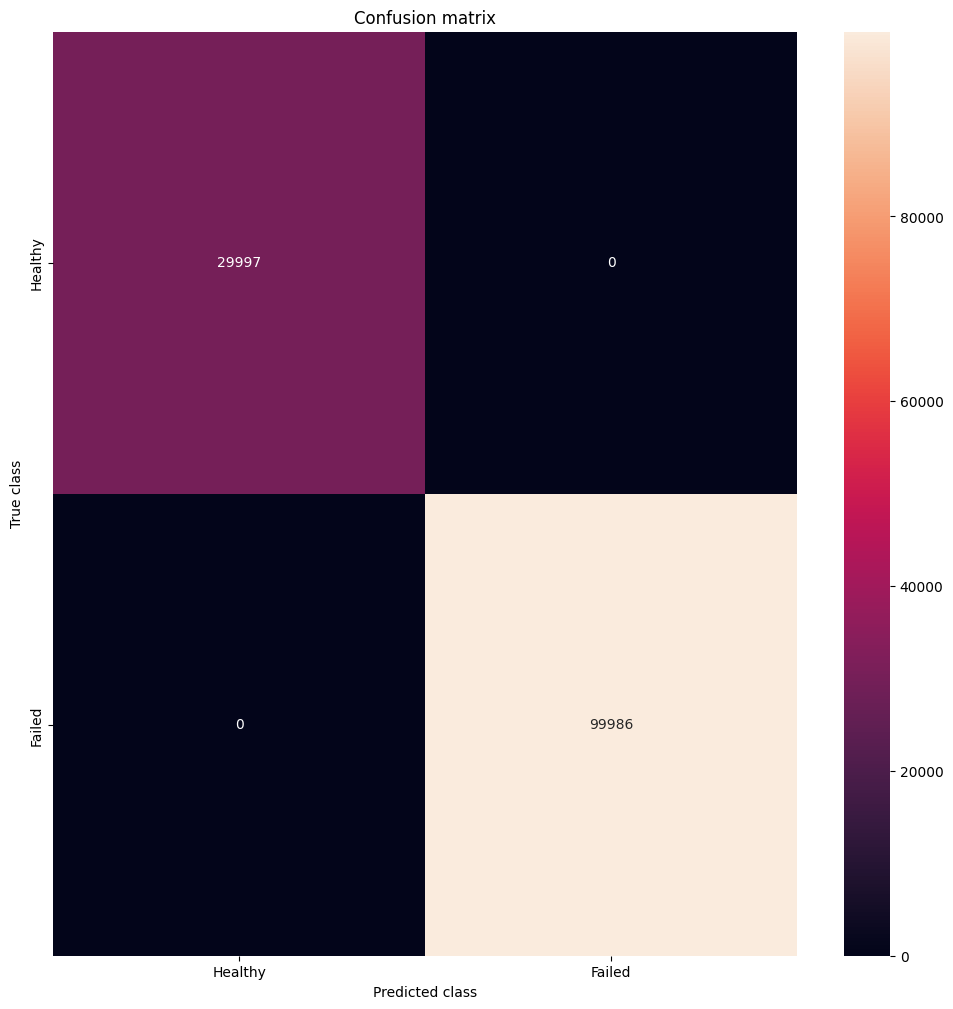

In [210]:
LABELS = ['Продажный', 'Непродажный']
conf_matrix = confusion_matrix(Y_test, yPred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d")
plt.title("Матрица ошибок")
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()


### вторая модель - используя метод разделения

In [211]:
xData = X_train.values
yData = Y_train.values

In [212]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(
        xData, yData, test_size = 0.2, random_state = 42)

In [213]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(xTrain, yTrain)

ypred = rfc.predict(xTest)

In [214]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

n_outliers = len(failed)
n_errors = (ypred != yTest).sum()
print("Используемая модель: Классификатор случайного леса")

acc = accuracy_score(yTest, ypred)
print("Точность составляет {}".format(acc))

prec = precision_score(yTest, ypred)
print("Точность (precision) составляет {}".format(prec))

rec = recall_score(yTest, ypred)
print("Полнота (recall) составляет {}".format(rec))

f1 = f1_score(yTest, ypred)
print("F1-мера (F1-Score) составляет {}".format(f1))

MCC = matthews_corrcoef(yTest, ypred)
print("Коэффициент корреляции Мэтьюса составляет {}".format(MCC))


Model used is : Random Forest classifier
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is1.0


### Визуализация

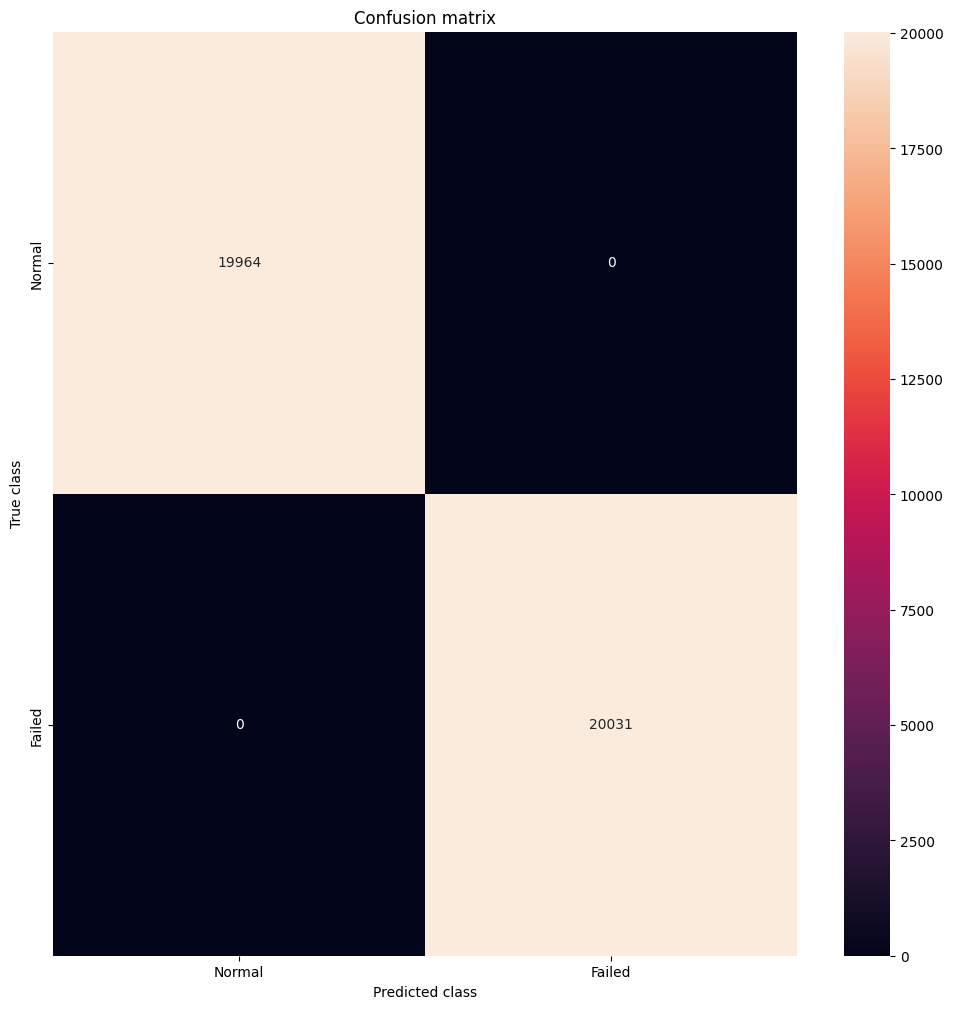

In [215]:
LABELS = ['Продажный', 'Непродажный']
conf_matrix = confusion_matrix(yTest, ypred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d")
plt.title("Матрица ошибок")
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()


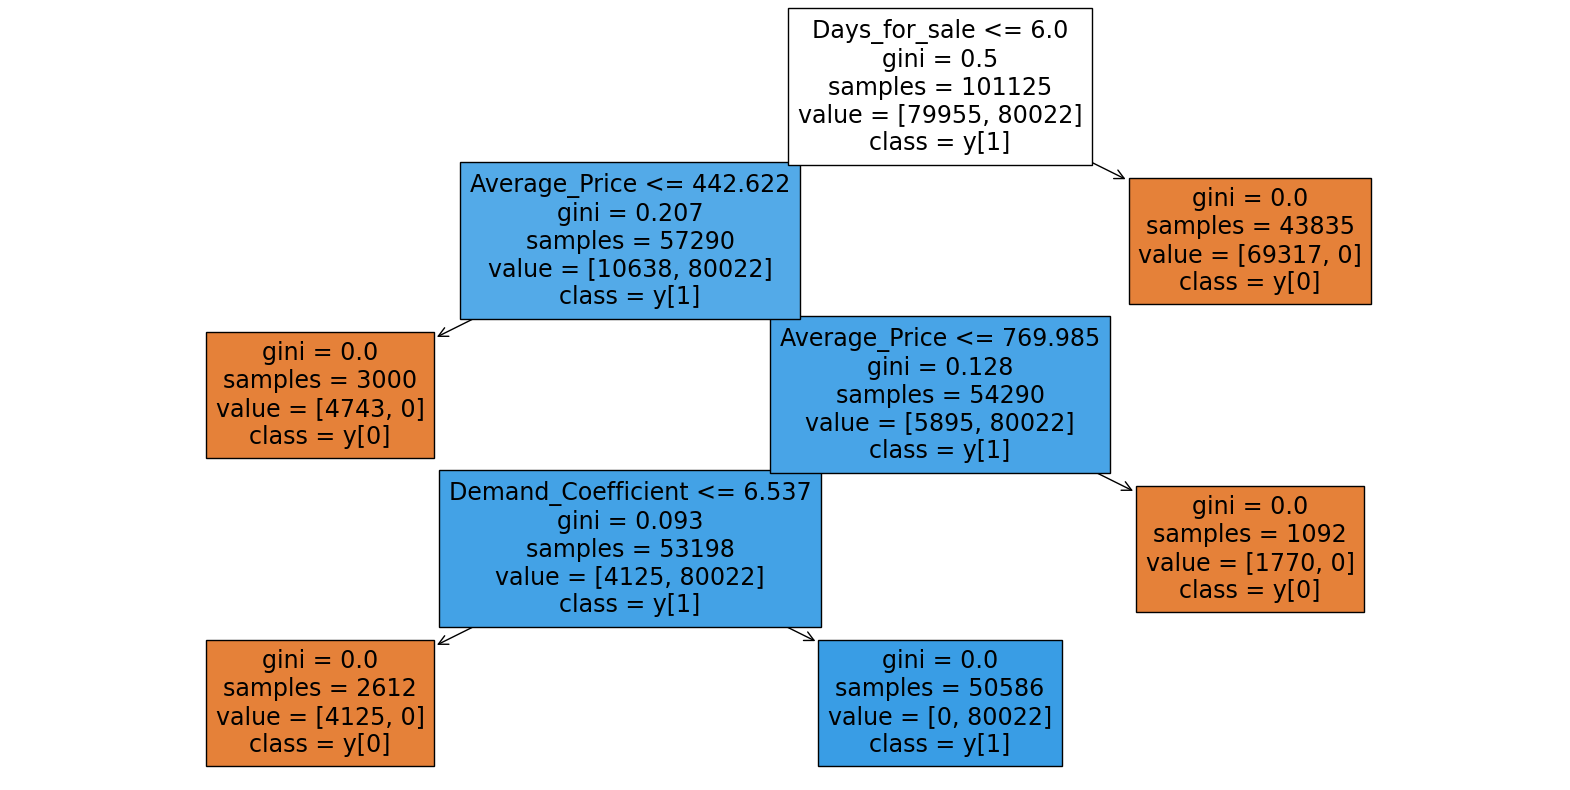

In [216]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

single_tree = rfc.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()